# Classifiers

Here we start to create ML system to recommend cans that other cats would probably like. For that we will train classifiers to distinguish yummy cat food from bad. So let's load already prepared file.

In [37]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('output.csv')

# Show general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   company         164 non-null    object 
 1   price           164 non-null    float64
 2   weight          164 non-null    float64
 3   star_rating     164 non-null    float64
 4   total_comments  164 non-null    float64
 5   adult           164 non-null    float64
 6   chicken         164 non-null    float64
 7   wet             164 non-null    float64
 8   from_oceon      164 non-null    float64
 9   salmon          164 non-null    float64
 10  mackerel        164 non-null    float64
 11  can             164 non-null    float64
 12  gravy           164 non-null    float64
 13  vegan           164 non-null    float64
dtypes: float64(13), object(1)
memory usage: 18.1+ KB


Classifiers work with numerical data only. Among 14 features we have one of non-numerical type, which requires encoding. Since this "company" doesn't have a natural order, we will use one-hot encoding. One-hot encoding is a technique that converts categorical data into a binary format, creating binary columns (0 or 1) for each category. Each category becomes a new binary column, and only one of these columns is "hot" (1) while the others are "cold" (0) for each row, indicating the presence or absence of that category. 

We use the pd.get_dummies function to perform one-hot encoding on the 'company' column in the DataFrame 'df'. This function creates binary columns for each unique category in the 'category' column. The resulting df_encoded DataFrame will contain one-hot encoded columns for each unique category, making it suitable for machine learning algorithms that require numerical input.

Since the number of features will increase, let's proceed with well represented companies only, those 7 of the 41 companies which products were bought at least 10 times.

As we see, after encoding we have 121 products described by 21 features.

In [38]:
row = ['whiskas', 'farmina', 'me-o', 'royal', 'purepet', 'purina', 'meat', 'sheba']

# Step 1: Use the Pandas 'get_dummies' function for one-hot encoding
df = pd.get_dummies(df[df.company.isin(row)], columns=['company'])

df.shape

(121, 21)

Now we need to choose a "teacher" to distinguish good cat food from bad. Let's consider the food as GOOD if star_rating is higher 4.5, otherwise as bad. 

Thus we have a new feature called "yummy".

In [39]:
# Define the threshold
threshold = 4.5

# Function to apply the threshold and create the new column
def binary_column(row):
    if row['star_rating'] >= threshold:
        return 1
    else:
        return 0

# Apply the function to create the new binary column
df['yummy'] = df.apply(binary_column, axis=1)

# Display the new column
df.yummy

0      0
1      0
2      1
4      0
6      1
      ..
154    0
156    1
157    0
159    1
161    0
Name: yummy, Length: 121, dtype: int64

Now let's check that the number of good and bad cases is comparable and the classes are balanced. To calculate the number of "0"s and "1"s in the 'yummy' column of a DataFrame, you can use the Pandas value_counts() method.

In [40]:
# Assuming "yummy" is the column of interest
counts = df['yummy'].value_counts()

# Print the counts
print("Counts of '0' and '1' in the 'yummy' column:")
print(counts)

Counts of '0' and '1' in the 'yummy' column:
0    64
1    57
Name: yummy, dtype: int64


Scaling the data is an essential step in data preprocessing, especially when dealing with features that have different scales. Common scaling techniques include Min-Max Scaling that scales the data to a specified range. As we see, now all the date range from 0 to 1.

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Assuming you have a DataFrame 'df' with numerical columns to scale
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(df)

# Create a new DataFrame with scaled data
df = pd.DataFrame(scaled_data, columns=df.columns)

# Display the scaled DataFrame
df.head(2)

,price,weight,star_rating,total_comments,adult,chicken,wet,from_oceon,salmon,mackerel,...,vegan,company_farmina,company_me-o,company_meat,company_purepet,company_purina,company_royal,company_sheba,company_whiskas,yummy
0,0.022888,0.113797,0.60,0.638163,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.128879,0.697885,0.65,0.904091,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now we load fix "yummy" as the target variable (y) and the remaining columns as features (X). Note, we should drop 'star_rating' and 'yummy' from features.

Than we split the data into training and testing sets using train_test_split.

In [42]:
from sklearn.model_selection import train_test_split

# Step 1: Prepare the data
# Assuming 'yummy' is the target column, and you have other columns as features
X = df.drop(['star_rating','yummy'], axis='columns')  # Features
y = df['yummy']  # Target variable ('yummy')

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Naive Bayes

To train a Naive Bayes classifier, make sure to install scikit-learn if you haven't already using pip install scikit-learn.

This code will allow you to create, train, and evaluate a Naive Bayes classifier for your dataset with the "yummy" column as the target variable:
- We create a Gaussian Naive Bayes classifier (GaussianNB) and train it on the training data.
- We make predictions on the test set.
- We evaluate the classifier's performance using accuracy and a confusion matrix.

According to Confusion Matrix, it detects good food quite well (all 10 cases). However, it is often wrong about bad food (7 out of 15 times). 72% accuracy is not too good.

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Create and train a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Step 2: Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Step 3: Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Step 4: Print the evaluation results
print("Accuracy:", accuracy)
print("Train Accuracy:", accuracy_score(y_train, nb_classifier.predict(X_train)))
print("Confusion Matrix:\n", confusion)

Accuracy: 0.72
Train Accuracy: 0.59375
Confusion Matrix:
 [[ 8  7]
 [ 0 10]]


To visualize the results of a trained classifier in 2D dimensions using two features, we create a scatter plot with decision boundaries to show how the classifier separates the data points. However, please note that the Gaussian Naive Bayes classifier may not provide a straightforward decision boundary visualization since it works well with continuous data, and visualizing decision boundaries is more common with classifiers like Support Vector Machines or Decision Trees.

Here we create a mesh grid to generate points for plotting decision boundaries. The classifier is used to make predictions on the mesh grid. Than we create a scatter plot with decision boundaries by plotting the mesh grid and overlaying the actual data points with different colors.

C:\Users\kater\.conda\envs\test\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


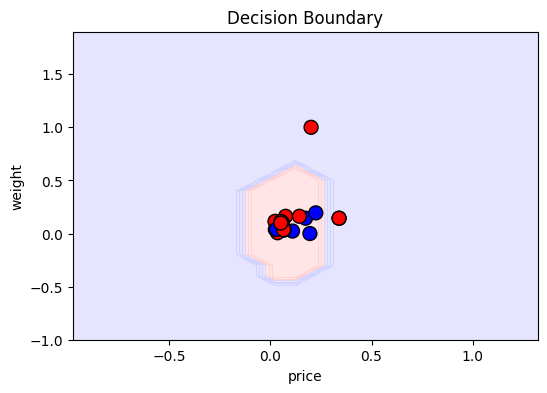

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Step 0: Select two features for visualization (change column names as needed)
feature1 = "price"
feature2 = "weight"

# Step 1: Create and train a Gaussian Naive Bayes classifier
classifier2 = GaussianNB()
classifier2.fit(X_train[[feature1, feature2]], y_train)
y_pred = classifier2.predict(X_test[[feature1, feature2]])

# Step 2: Extract the selected features from the test set
X_test_2d = X_test[[feature1, feature2]].values

# Step 3: Create a mesh grid for the plot
h = .1  # Step size in the mesh
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Step 4: Use the classifier to make predictions on the mesh grid
Z = classifier2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 5: Create a scatter plot with decision boundaries
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cmap_points, edgecolors='k', marker='o', s=100)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Decision Boundary")
plt.show()

## Logistic regression

To create Logistic Regression Classifier we use LogisticRegression() method. Than we train the classifier on the training data using fit() method.

Finally, we evaluate the classifier's accuracy on the testing data using accuracy and a confusion matrix.

Logistic Regression classifier handles the bad food better (12 of 15 recognized correctly) with 72% accuracy.

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Step 1: Create a Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Step 2: Train the classifier on the training data
logistic_regression_classifier.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = logistic_regression_classifier.predict(X_test)

# Step 4: Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Step 5: Print the evaluation results
print("Accuracy:", accuracy)
#print("Train Accuracy:", accuracy_score(y_train, logistic_regression_classifier.predict(X_train)))
print("Confusion Matrix:\n", confusion)

Accuracy: 0.72
Confusion Matrix:
 [[12  3]
 [ 4  6]]


To visualize the results of a trained classifier in 2D dimensions using two features, we create a scatter plot with decision boundaries to show how the classifier separates the data points. 

C:\Users\kater\.conda\envs\test\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


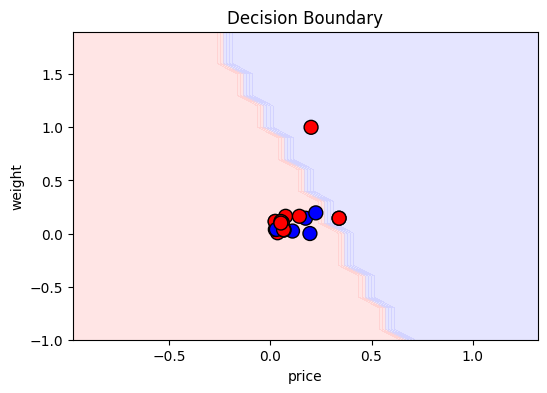

In [46]:
# Step 1: Create and train a classifier
classifier2 = LogisticRegression()
classifier2.fit(X_train[[feature1, feature2]], y_train)
y_pred = classifier2.predict(X_test[[feature1, feature2]])

# Step 2: Extract the selected features from the test set
X_test_2d = X_test[[feature1, feature2]].values

# Step 3: Create a mesh grid for the plot
h = .1  # Step size in the mesh
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Step 4: Use the classifier to make predictions on the mesh grid
Z = classifier2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 5: Create a scatter plot with decision boundaries
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cmap_points, edgecolors='k', marker='o', s=100)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Decision Boundary")
plt.show()

To display the importance of features for a trained Logistic Regression classifier, we access the coefficients of the model. The coefficients represent the weights of each feature in the decision-making process. Features with higher absolute coefficients have a greater impact on the classification decision. 

To access the coefficients of the trained Logistic Regression model we use logreg_classifier.coef_. We create a DataFrame (coef_df) to store the feature names and their corresponding coefficients and calculate the absolute values of the coefficients and sort the features by their absolute coefficients in descending order to display the most important features.

We use a horizontal bar chart to visualize the feature importances.

This code will display a bar chart showing the importance of each feature in the trained Logistic Regression classifier. Features with higher absolute coefficients are considered more important for the classification decision. The most important features for Logistic Regressor Classifier are 'price' and 'weight'.

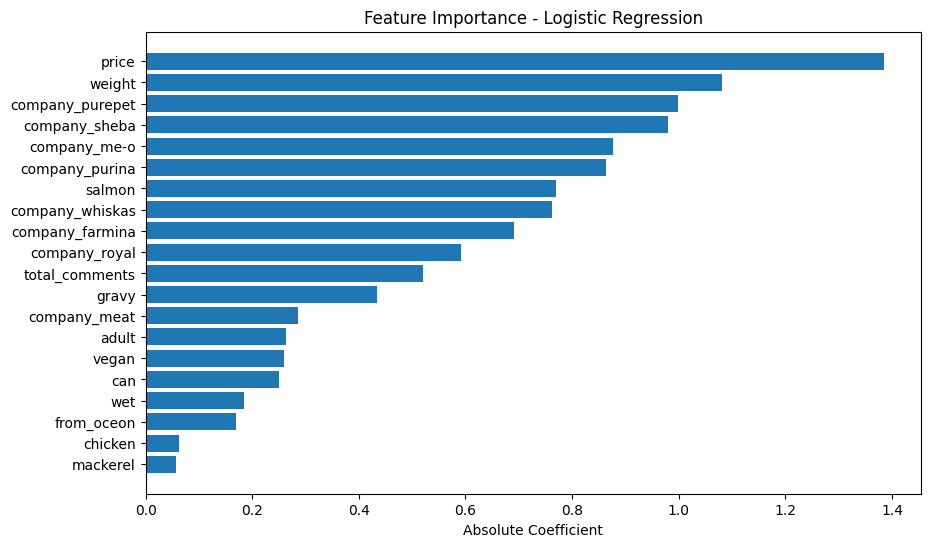

In [47]:
import matplotlib.pyplot as plt
# Assuming you have already trained a Logistic Regression classifier and stored it in 'logreg_classifier'

# Get the feature names (column names) from your DataFrame
feature_names = X_train.columns  # Replace with your feature DataFrame (X_train)

# Get the coefficients (importance) of each feature
coefficients = logistic_regression_classifier.coef_[0]

# Create a DataFrame to store feature names and their coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the features by their absolute coefficients to display the most important ones
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_coef_df['Feature'], sorted_coef_df['Absolute_Coefficient'])
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance - Logistic Regression')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

## KNN

Here we create and train a K-Nearest Neighbors (KNN) classifier. First we replace k with the desired number of neighbors for the KNN classifier.The value of k determines how many nearest neighbors will be considered when making predictions.  Let it be 3. 

The KNN classifier is trained on the training data (X_train and y_train). Predictions are made on the test data (X_test).

The classifier's performance is evaluated using accuracy and a confusion matrix. 
KNN performs quite well, with an accuracy of 84%. 

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Step 1: Create a KNN classifier
k = 3  # Replace with your desired number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Step 2: Train the KNN classifier on the training data
knn_classifier.fit(X_train, y_train)

# Step 3: Make predictions on the test data
y_pred = knn_classifier.predict(X_test)

# Step 4: Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Step 5: Print the evaluation results
print("Accuracy:", accuracy)
#print("Train Accuracy:", accuracy_score(y_train, knn_classifier.predict(X_train)))
print("Confusion Matrix:\n", confusion)

Accuracy: 0.84
Confusion Matrix:
 [[11  4]
 [ 0 10]]


To visualize the results of a trained classifier in 2D dimensions using two features, we create a scatter plot with decision boundaries to show how the classifier separates the data points. 

C:\Users\kater\.conda\envs\test\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


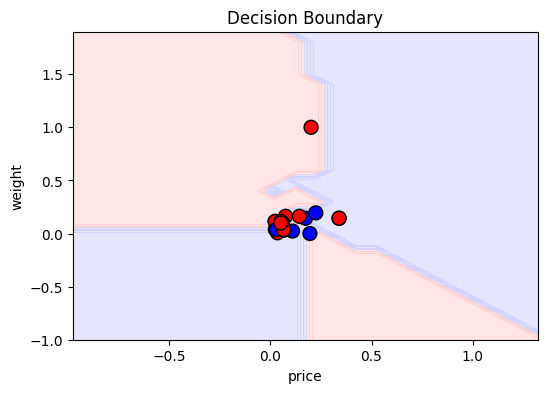

In [49]:
# Step 1: Create and train a classifier
classifier2 = KNeighborsClassifier(n_neighbors=k)
classifier2.fit(X_train[[feature1, feature2]], y_train)
y_pred = classifier2.predict(X_test[[feature1, feature2]])

# Step 2: Extract the selected features from the test set
X_test_2d = X_test[[feature1, feature2]].values

# Step 3: Create a mesh grid for the plot
h = .1  # Step size in the mesh
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Step 4: Use the classifier to make predictions on the mesh grid
Z = classifier2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 5: Create a scatter plot with decision boundaries
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cmap_points, edgecolors='k', marker='o', s=100)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Decision Boundary")
plt.show()

## SVM

The SVC class from scikit-learn is used to create an SVM classifier with a linear kernel. You can choose a different kernel, such as 'rbf' (Radial basis function) or 'poly', depending on your problem and dataset.

The SVM classifier is trained on the training data (X_train and y_train). Predictions are made on the test data (X_test).

The classifier's performance is evaluated using accuracy and a confusion matrix. SVM performs best, with an accuracy of 92%. It was wrong in only 2 cases of bad food recognition.

In [50]:
from sklearn.svm import SVC

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Step 1: Create an SVM classifier
svm_classifier = SVC(kernel='rbf')  # You can choose a different kernel: 'linear', 'sigmoid', 'rbf', 'poly'

# Step 2: Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Step 3: Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Step 4: Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Step 5: Print the evaluation results
print("Accuracy:", accuracy)
#print("Train Accuracy:", accuracy_score(y_train, svm_classifier.predict(X_train)))
print("Confusion Matrix:\n", confusion)

Accuracy: 0.92
Confusion Matrix:
 [[13  2]
 [ 0 10]]


To visualize the results of a trained classifier in 2D dimensions using two features, we create a scatter plot with decision boundaries to show how the classifier separates the data points. 

C:\Users\kater\.conda\envs\test\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


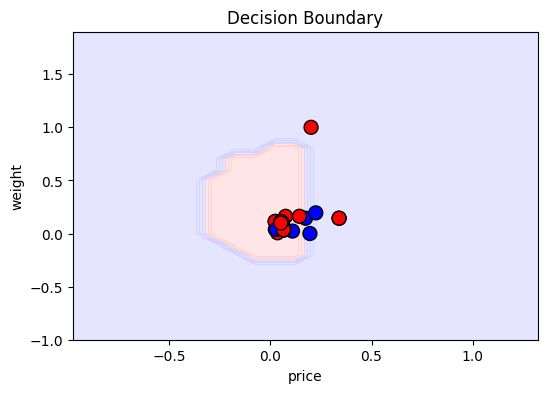

In [51]:
# Step 1: Create and train a classifier
classifier2 = SVC(kernel='rbf') 
classifier2.fit(X_train[[feature1, feature2]], y_train)
y_pred = classifier2.predict(X_test[[feature1, feature2]])

# Step 2: Extract the selected features from the test set
X_test_2d = X_test[[feature1, feature2]].values

# Step 3: Create a mesh grid for the plot
h = .1  # Step size in the mesh
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Step 4: Use the classifier to make predictions on the mesh grid
Z = classifier2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 5: Create a scatter plot with decision boundaries
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cmap_points, edgecolors='k', marker='o', s=100)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Decision Boundary")
plt.show()

## Tree

The DecisionTreeClassifier class from scikit-learn is used to create a Decision Tree classifier. You can adjust hyperparameters as needed, such as max_depth, min_samples_split, or others, to control the tree's complexity.

The Decision Tree classifier is trained on the training data (X_train and y_train). Predictions are made on the test data (X_test).

The classifier's performance is evaluated using accuracy and a confusion matrix. Decision Tree performs worst on the test data (with 68% accuracy). This model seems to be overfitted with Train Accuracy: 1.0.

In [52]:
from sklearn.tree import DecisionTreeClassifier

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Step 1: Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)  # You can adjust hyperparameters as needed

# Step 2: Train the Decision Tree classifier on the training data
dt_classifier.fit(X_train, y_train)

# Step 3: Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Step 4: Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Step 5: Print the evaluation results
print("Accuracy:", accuracy)
print("Train Accuracy:", accuracy_score(y_train, dt_classifier.predict(X_train)))
print("Confusion Matrix:\n", confusion)

Accuracy: 0.68
Train Accuracy: 1.0
Confusion Matrix:
 [[11  4]
 [ 4  6]]


To display the importance of features for a trained Decision Tree (DT) classifier, you can access the feature importances provided by the classifier. We access the feature importances of the trained Decision Tree classifier using dt_classifier.feature_importances_. 

Than we create a DataFrame (importance_df) to store the feature names and their corresponding importances, and sort the features by their importances in descending order to display the most important features. We use a horizontal bar chart to visualize the feature importances. The most important features for Desission Tree Classifier are 'total_coments' and 'price'.

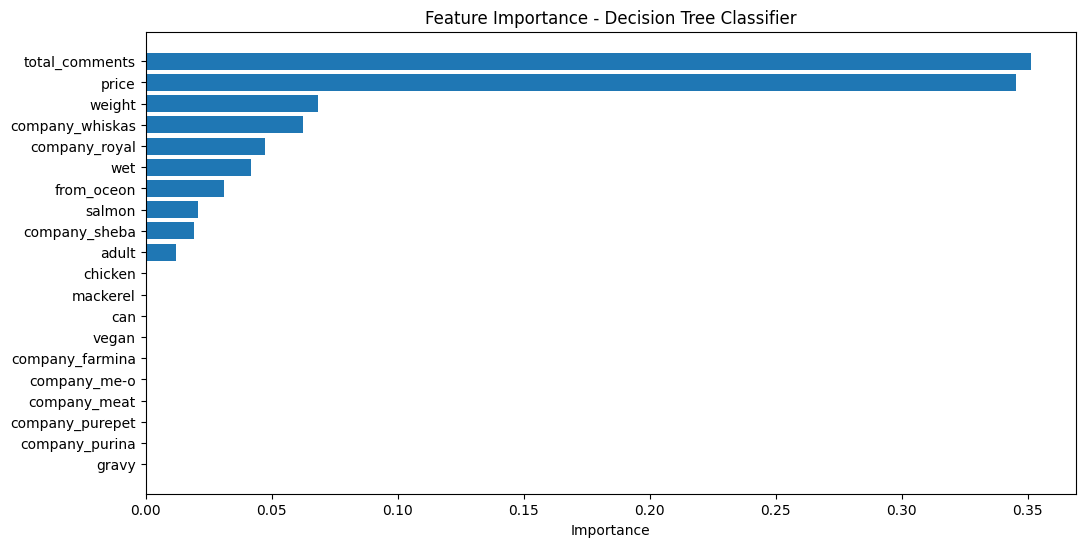

In [53]:
# Assuming you have already trained a Decision Tree classifier and stored it in 'dt_classifier'

# Get the feature names (column names) from your DataFrame
feature_names = X_train.columns  # Replace with your feature DataFrame (X_train)

# Get the feature importances from the trained Decision Tree classifier
feature_importances = dt_classifier.feature_importances_

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by their importances in descending order to display the most important ones
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

To display the tree structure of a trained Decision Tree classifier, you can use the plot_tree function from scikit-learn. 

We specify the figure size using plt.figure(figsize=(10, 15)) to adjust the size of the tree visualization as needed.

We use the plot_tree function to display the tree structure. The filled=True argument fills the decision boxes with colors, and the feature_names argument provides the feature names for labeling the nodes. The class_names argument specifies the class labels.

Finally, we show the plot using plt.show.

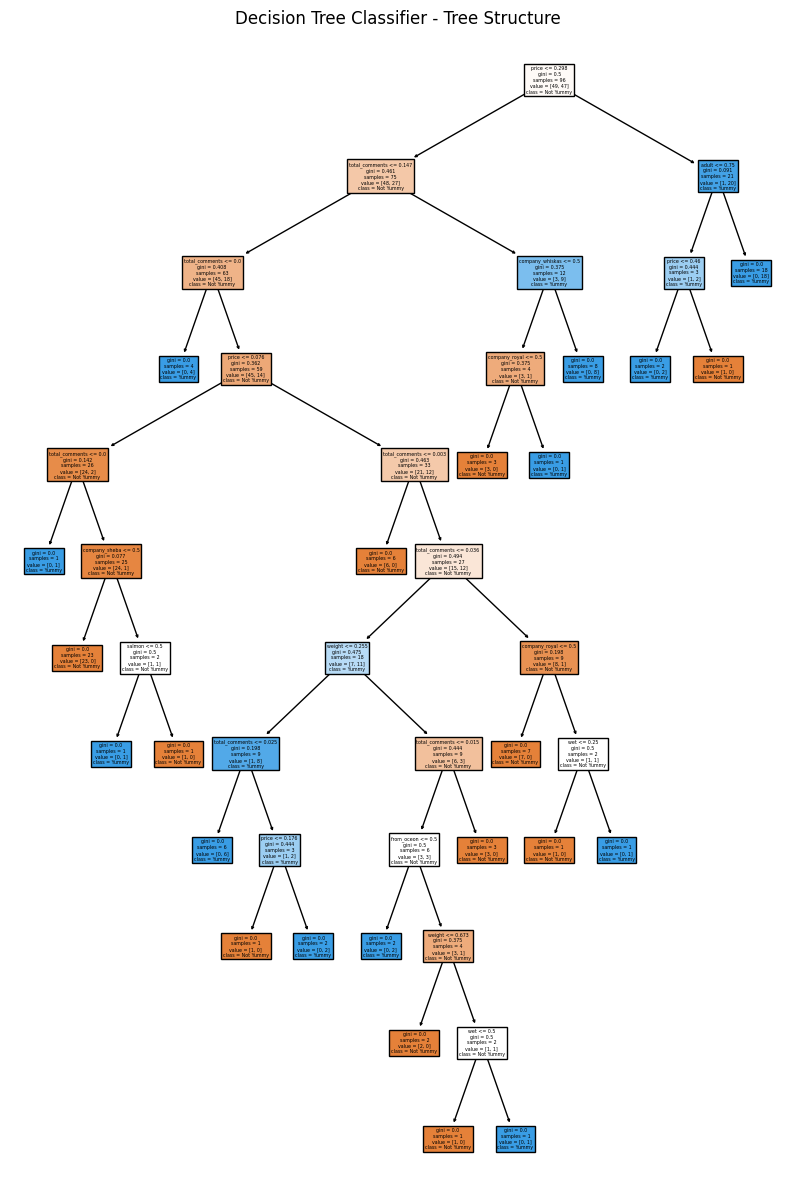

In [54]:
from sklearn.tree import plot_tree

# Display the tree structure
plt.figure(figsize=(10, 15))  # Adjust the figure size as needed
plot_tree(dt_classifier, filled=True, feature_names=feature_names, class_names=['Not Yummy', 'Yummy'])
plt.title("Decision Tree Classifier - Tree Structure")
plt.show()

To visualize the results of a trained classifier in 2D dimensions using two features, we create a scatter plot with decision boundaries to show how the classifier separates the data points. 

C:\Users\kater\.conda\envs\test\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


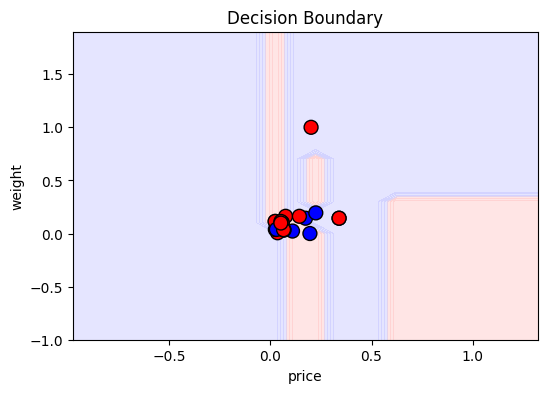

In [55]:
# Step 1: Create and train a classifier
classifier2 = DecisionTreeClassifier(random_state=42)
classifier2.fit(X_train[[feature1, feature2]], y_train)
y_pred = classifier2.predict(X_test[[feature1, feature2]])

# Step 2: Extract the selected features from the test set
X_test_2d = X_test[[feature1, feature2]].values

# Step 3: Create a mesh grid for the plot
h = .1  # Step size in the mesh
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Step 4: Use the classifier to make predictions on the mesh grid
Z = classifier2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 5: Create a scatter plot with decision boundaries
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=cmap_points, edgecolors='k', marker='o', s=100)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Decision Boundary")
plt.show()

## Feed Forward Neural Network Classifier

To create and train a Neural Network (NN) Classifier using Python, assuming you already have training and test subsets of your dataset named X_train, y_train (for training data), and X_test, y_test (for test data), we use libraries like TensorFlow or PyTorch. Here's an example using TensorFlow.

We define the architecture of the neural network using tf.keras.Sequential, which allows us to stack layers sequentially. Here, we have two hidden layers with 64 neurons each and ReLU activation functions, followed by an output layer with 1 neuron for binary classification using a sigmoid activation function.

With 64 neurons in two hidden layers, the NN is overfitted. Read the manuals carefully before using deep NNs to solve your problems.

We compile the model using the Adam optimizer and binary cross-entropy loss function, suitable for binary classification tasks. Additionally, we specify to monitor the accuracy metric during training.

Than we train the model on the training data (X_train, y_train) for 100 epochs, specifying the validation data (X_test, y_test) for evaluation during training.

The training progress is stored in the history variable.

Finally, we evaluate the trained model on the test data and print the test loss and accuracy.

In [56]:
import tensorflow as tf

# Define the architecture of the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/100
3/3 [==============================] - 0s 55ms/step - loss: 0.6814 - accuracy: 0.5938 - val_loss: 0.6720 - val_accuracy: 0.6400
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6650 - accuracy: 0.6562 - val_loss: 0.6664 - val_accuracy: 0.7200
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6552 - accuracy: 0.7292 - val_loss: 0.6596 - val_accuracy: 0.7600
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6441 - accuracy: 0.7708 - val_loss: 0.6533 - val_accuracy: 0.7200
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6346 - accuracy: 0.7604 - val_loss: 0.6474 - val_accuracy: 0.7200
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6244 - accuracy: 0.7604 - val_loss: 0.6397 - val_accuracy: 0.7200
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6151 - accuracy: 0.7708 - val_loss: 0.6319 - val_accuracy: 0.7200
Epoch 8/100
3/3 [===

3/3 [==============================] - 0s 8ms/step - loss: 0.2892 - accuracy: 0.8958 - val_loss: 0.4665 - val_accuracy: 0.7600
Epoch 60/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2866 - accuracy: 0.8958 - val_loss: 0.4685 - val_accuracy: 0.7600
Epoch 61/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2815 - accuracy: 0.8854 - val_loss: 0.4719 - val_accuracy: 0.7600
Epoch 62/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2782 - accuracy: 0.9062 - val_loss: 0.4755 - val_accuracy: 0.7600
Epoch 63/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2742 - accuracy: 0.9062 - val_loss: 0.4777 - val_accuracy: 0.7600
Epoch 64/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2710 - accuracy: 0.9062 - val_loss: 0.4795 - val_accuracy: 0.7600
Epoch 65/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2679 - accuracy: 0.9062 - val_loss: 0.4847 - val_accuracy: 0.7600
Epoch 66/100
3/3 [============

To calculate a confusion matrix for a Neural Network (NN) classifier, you can use scikit-learn's confusion_matrix function.
We predict the classes for the test data using the trained model. For binary classification, we typically use a threshold of 0.5 to convert probabilities to binary predictions.

Than we calculate the confusion matrix using confusion_matrix from scikit-learn, passing the true labels (y_test) and predicted classes (predicted_classes).

In [57]:
from sklearn.metrics import confusion_matrix

# Predict on test data
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype('int')  # Convert probabilities to binary predictions

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

1/1 [==============================] - 0s 39ms/step


Finally, we print the Accuracy and confusion matrix.

FFNN performed worse than SVM, but better than other classifiers. 

In [58]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.6800000071525574
Confusion Matrix:
[[11  4]
 [ 4  6]]


At the end, we save prepared data - encoded and scaled.

In [59]:
df.to_csv('output_classifiers.csv', index=False)

In [60]:
!jupyter nbconvert 02_Classifiers --to html

[NbConvertApp] Converting notebook 02_Classifiers.ipynb to html
[NbConvertApp] Writing 1109932 bytes to 02_Classifiers.html
